# Preparación del Dataset: Intel Image Classification con PyTorch

**Objetivo:** Cargar el dataset "Intel Image Classification", aplicar preprocesamiento y aumento de datos, y crear DataLoaders de PyTorch para entrenamiento, validación y prueba.

**Dataset:** [Intel Image Classification en Kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
Contiene imágenes de 150x150 píxeles en 6 categorías: buildings, forest, glacier, mountain, sea, street.

## 1. Configuración Inicial: Importación de Librerías

Importamos todas las librerías necesarias para el proyecto. Esto incluye PyTorch, Torchvision, Pillow (PIL) para imágenes, y `matplotlib` para visualización.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import os
import time
import copy

## 2. Definición de rutas al dataset

* `train/`: Contiene las imágenes para el entrenamiento del modelo.
* `validation/`: Contiene las imágenes para la validación del modelo durante el entrenamiento.
* `test/`: Contiene las imágenes para la prueba final del modelo.

In [ ]:
from google.colab import drive

# Montar Google Drive para poder acceder al .zip
drive.mount('/content/drive')

# Copiar y descomprimir el dataset en el entorno local de Colab
!cp "/content/drive/My Drive/ProyectoRNP/data.zip" "/content/"
!unzip -q -o "/content/data.zip" -d "/content/data/"

# Carpeta base del proyecto
project_base_dir = Path('/content/drive/My Drive/ProyectoRNP')

# Carpeta base del colab
data_dir = Path('/content/data')

# Subcarpetas que contienen las imágenes
train_dir = data_dir / 'train'
val_dir = data_dir / 'validation'
test_dir = data_dir / 'test'

Mounted at /content/drive


## 3. Definición de Transformaciones de Preprocesamiento

Antes de que nuestras imágenes puedan ser alimentadas a la red neuronal, necesitamos aplicarles una serie de transformaciones. Estas aseguran que todas las imágenes tengan un formato consistente (ej. mismo tamaño) y estén normalizadas, lo cual puede ayudar significativamente al proceso de entrenamiento.

Usaremos los valores estándar de media y desviación de ImageNet para la normalización, ya que es una práctica común, especialmente si planeamos usar un modelo preentrenado.

In [ ]:
image_crop_size = 224
resize_to = 256
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        # Recorte aleatorio: fuerza al modelo a encontrar el objeto aunque no esté centrado.
        transforms.RandomResizedCrop(image_crop_size, scale=(0.8, 1.0)),
        # Volteo horizontal: la aumentación más común y efectiva.
        transforms.RandomHorizontalFlip(),
        # Cambios de color: hace que el modelo sea menos sensible a tonos específicos de azul y blanco.
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
        # Rotación: simula diferentes ángulos de cámara.
        transforms.RandomRotation(15),
        # Transformaciones estándar
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ]),

    'validation': transforms.Compose([
        transforms.Resize(resize_to),
        transforms.CenterCrop(image_crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(resize_to),
        transforms.CenterCrop(image_crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ]),
}

print("Transformaciones actualizadas con Aumento de Datos más agresivo.")

Transformaciones actualizadas con Aumento de Datos más agresivo.


## 4. Creación de los Datasets de PyTorch

Para este tipo de problema, donde las imágenes están organizadas en subcarpetas por clase, la clase `torchvision.datasets.ImageFolder` es ideal.

`ImageFolder` se encarga de encontrar las imágenes, asociarlas con sus clases correctas (el nombre de la subcarpeta se convierte en el nombre de la clase) y aplicar las transformaciones definidas cuando se accede a cada imagen.

Crearemos tres objetos `Dataset`: uno para entrenamiento (`train_dataset`), uno para validación (`val_dataset`) y uno para prueba (`test_dataset`).

In [ ]:
class LandscapeDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string o Path): Directorio raíz que contiene las subcarpetas de cada clase.
            transform (callable, optional): Transformaciones a aplicar a cada imagen.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform

        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])

        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.classes)}

        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            for img_path in class_dir.glob('*.*'):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        """Devuelve el número total de imágenes en el dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Permite obtener una muestra (imagen y etiqueta) del dataset dado un índice `idx`."""
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Crear los Datasets usando nuestra clase personalizada LandscapeDataset

try:
    train_dataset = LandscapeDataset(root_dir=train_dir, transform=data_transforms['train'])
    val_dataset = LandscapeDataset(root_dir=val_dir, transform=data_transforms['validation'])
    test_dataset = LandscapeDataset(root_dir=test_dir, transform=data_transforms['test'])

    print("Datasets creados exitosamente con la clase personalizada.")

    print(f"\nInformación del Dataset de Entrenamiento:")
    print(f"  Número de imágenes: {len(train_dataset)}")
    print(f"  Clases encontradas: {train_dataset.classes}")
    print(f"  Mapeo de clases a índices: {train_dataset.class_to_idx}")

    print(f"\nInformación del Dataset de Validación:")
    print(f"  Número de imágenes: {len(val_dataset)}")
    print(f"  Clases encontradas: {val_dataset.classes}")
    print(f"  Mapeo de clases a índices: {val_dataset.class_to_idx}")

    print(f"\nInformación del Dataset de Prueba:")
    print(f"  Número de imágenes: {len(test_dataset)}")
    print(f"  Clases encontradas: {test_dataset.classes}")
    print(f"  Mapeo de clases a índices: {test_dataset.class_to_idx}")

except Exception as e:
    print(f"Error al crear los Datasets con la clase personalizada: {e}")
    print("Asegúrate de que las rutas a los directorios (train_dir, val_dir, test_dir) sean correctas y")
    print("que dentro de cada uno existan subcarpetas para cada clase (ej. 'buildings', 'forest', etc.) conteniendo las imágenes.")

Datasets creados exitosamente con la clase personalizada.

Información del Dataset de Entrenamiento:
  Número de imágenes: 10493
  Clases encontradas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
  Mapeo de clases a índices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Información del Dataset de Validación:
  Número de imágenes: 2505
  Clases encontradas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
  Mapeo de clases a índices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Información del Dataset de Prueba:
  Número de imágenes: 2692
  Clases encontradas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
  Mapeo de clases a índices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


## 5. Creación de los DataLoaders

Una vez que tenemos nuestros objetos `Dataset`, el siguiente paso es crear `DataLoader` para cada uno. Los `DataLoader` son iteradores que nos proporcionan los datos en lotes (batches) durante el entrenamiento y la evaluación. También se encargan de tareas importantes como mezclar los datos del conjunto de entrenamiento (`shuffle=True`) para asegurar que el modelo no vea los datos en el mismo orden en cada época, y pueden paralelizar la carga de datos (`num_workers`).

In [ ]:
# Definimos el tamaño del lote (batch_size).
batch_size = 32

# Crear los DataLoaders
try:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    print("DataLoaders creados exitosamente.")
    print(f"Tamaño del lote (batch_size): {batch_size}")
    print(f"Número de lotes en train_loader: {len(train_loader)}")
    print(f"Número de lotes en val_loader: {len(val_loader)}")
    print(f"Número de lotes en test_loader: {len(test_loader)}")

    # Guardamos los tamaños de los datasets para referencia futura si es necesario
    dataset_sizes = {
        'train': len(train_dataset),
        'validation': len(val_dataset),
        'test': len(test_dataset)
    }
    print(f"\nTamaños de los datasets: {dataset_sizes}")

    # También guardamos los nombres de las clases
    class_names = train_dataset.classes
    print(f"Nombres de las clases: {class_names}")
    num_classes = len(class_names)
    print(f"Número de clases: {num_classes}")


except Exception as e:
    print(f"Error al crear los DataLoaders: {e}")
    print("Asegúrate de que los objetos train_dataset, val_dataset y test_dataset se hayan creado correctamente en el paso anterior.")

DataLoaders creados exitosamente.
Tamaño del lote (batch_size): 32
Número de lotes en train_loader: 328
Número de lotes en val_loader: 79
Número de lotes en test_loader: 85

Tamaños de los datasets: {'train': 10493, 'validation': 2505, 'test': 2692}
Nombres de las clases: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Número de clases: 6


## 6. Visualización y Verificación de un Lote de Datos

Para asegurarnos de que nuestros `DataLoader` están funcionando correctamente y que las transformaciones de imágenes se aplican como esperamos, vamos a obtener un lote (batch) de datos del `train_loader` y visualizaremos algunas de sus imágenes junto con sus etiquetas correspondientes.

Visualizando algunas imágenes del primer lote de entrenamiento:
Shape del tensor de imágenes del lote: torch.Size([32, 3, 224, 224])
Shape del tensor de etiquetas del lote: torch.Size([32])


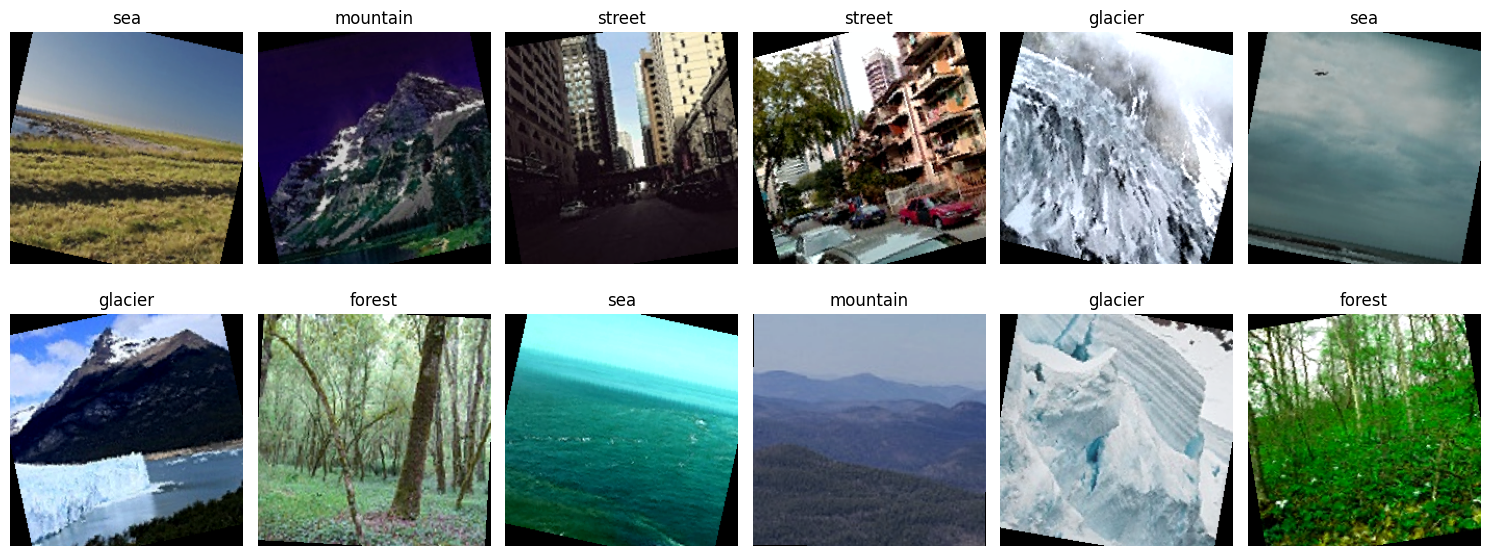

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

try:
    if 'train_loader' in globals() and len(train_loader) > 0:
        images, labels = next(iter(train_loader))

        num_images_to_show = 12
        num_cols = 6
        num_rows = (num_images_to_show - 1) // num_cols + 1

        plt.figure(figsize=(15, num_rows * 3))

        print("Visualizando algunas imágenes del primer lote de entrenamiento:")
        print(f"Shape del tensor de imágenes del lote: {images.shape}")
        print(f"Shape del tensor de etiquetas del lote: {labels.shape}")

        for i in range(num_images_to_show):
            if i < len(images):
                plt.subplot(num_rows, num_cols, i + 1)

                title = class_names[labels[i].item()]
                imshow(images[i], title=title)
                plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("train_loader no está definido o está vacío. No se pueden mostrar imágenes.")

except Exception as e:
    print(f"Ocurrió un error al intentar visualizar las imágenes: {e}")

In [ ]:
# Selección del dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"Dispositivo utilizado: {device}")
    print(f"Nombre de la GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria disponible: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Dispositivo utilizado: {device}")
else:
    device = torch.device("cpu")
    print(f"Dispositivo utilizado: {device}")
    print("Usando CPU para el entrenamiento")

torch.backends.cudnn.benchmark = True if torch.cuda.is_available() else False
print(f"\nDispositivo utilizado:: {device}")

Dispositivo utilizado: cuda:0
Nombre de la GPU: Tesla T4
Memoria disponible: 14.7 GB

Dispositivo utilizado:: cuda:0
